In [3]:
import torch
import clip
from PIL import Image

In [4]:
! ls /data/liangkongming/data/czsl/vaw-czsl/sub_images/2326474004_blue+elephant.jpg              

/data/liangkongming/data/czsl/vaw-czsl/sub_images/2326474004_blue+elephant.jpg


In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image_path = '/data/liangkongming/data/czsl/vaw-czsl/sub_images/2326474004_blue+elephant.jpg'
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
text = clip.tokenize(["blue", "elephant", "cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[1.744e-02 9.824e-01 1.683e-04]]


In [66]:
image_features = image_features / image_features.norm(dim=-1, keepdim=True)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)
logit_scale = model.logit_scale.exp()
logits = logit_scale * image_features @ text_features.t()

### Evaluate Vaw using CLIP

In [51]:
import os.path as osp
import json

def load_json(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

data_dir = '/data/liangkongming/code/KGVA/data/wxr/VAW_Clean_0_1/data'
attribute_to_index = load_json(osp.join(data_dir, 'attribute_index.json'))
object_to_index = load_json(osp.join(data_dir, 'object_index.json'))
anno = load_json(osp.join(data_dir, 'test.json'))

In [71]:
from glob import glob

def pred_image(model, anno_image):
    object_name = anno_image['object_name']
    prompt_template="a photo of "
    attribute_object_pairs = [prompt_template + x + ' ' + object_name for x in attribute_to_index]
    bbox = anno_image['instance_bbox']
    bbox = list(map(int, bbox))
    image_path = glob('/data/liangkongming/data/VG/*/{}.jpg'.format(anno_image['image_id']))[0]
    image = Image.open(image_path)
    image_crop = image.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))
    image = preprocess(image_crop).unsqueeze(0).to(device)
    text = clip.tokenize(attribute_object_pairs).to(device)

    with torch.no_grad():
#         image_features = model.encode_image(image)
#         text_features = model.encode_text(text)
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    return probs

In [ ]:
import numpy as np
from tqdm import tqdm

pred = np.zeros((len(anno), len(attribute_to_index)), dtype=np.float32)
for index in tqdm(range(len(anno))):
    anno_image = anno[index]
    pred[index] = pred_image(model, anno_image)

 19%|█████████▏                                       | 3961/21082 [22:29<1:36:25,  2.96it/s]

In [46]:
len(anno)

31819

linoleum


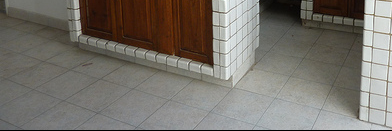

In [42]:
index = 70
anno_image = anno[index]
object_name = anno_image['object_name']
print(object_name)
prompt_template="a photo of "
attribute_object_pairs = [prompt_template + x + ' ' + object_name for x in attribute_to_index]
bbox = anno_image['instance_bbox']
bbox = list(map(int, bbox))
image_path = glob('/data/liangkongming/data/VG/*/{}.jpg'.format(anno_image['image_id']))[0]
image = Image.open(image_path)
image_crop = image.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))
image_crop

In [43]:
top_k_list = find_top_k(pred[index])
pred_attributes = []
for x in top_k_list:
    pred_attributes.append(index_to_attribute[x])
print(pred_attributes)

['stone', 'tiled', 'cobblestone', 'side view', 'shingled']


In [44]:
anno_image['positive_attributes'], anno_image['negative_attributes']

(['tiled'], ['on the wall'])

### Visualization

In [21]:
index_to_attribute = {v:k for k, v in attribute_to_index.items()}

def find_top_k(input_list, K=5):
    index_list = np.argsort(input_list)[-K::]
    index_list = index_list[::-1]
    return index_list

wire
pos ['thin']
neg ['horizontal', 'silver', 'colorful', 'dark', 'large', 'thick']
pred ['arrow shaped', 'blue striped', 'leaning forward', 'light blue', 'straight']


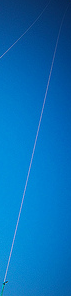

In [228]:
import random

index = random.randint(0, len(anno))
anno_image = anno[index]
object_name = anno_image['object_name']
prompt_template="a photo of "
# prompt_template=""
attribute_object_pairs = [prompt_template + x + ' ' + object_name for x in attribute_to_index]
bbox = anno_image['instance_bbox']
bbox = list(map(int, bbox))
image_path = glob('/data/liangkongming/data/VG/*/{}.jpg'.format(anno_image['image_id']))[0]
image = Image.open(image_path)
image_crop = image.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))
image = preprocess(image_crop).unsqueeze(0).to(device)
text = clip.tokenize(attribute_object_pairs).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print(object_name)
print('pos', anno_image['positive_attributes'])
print('neg', anno_image['negative_attributes'])
top_k_list = find_top_k(probs[0])
pred_attributes = []
for x in top_k_list:
    pred_attributes.append(index_to_attribute[x])
print('pred', pred_attributes)
image_crop

In [67]:
for pos_att in positive_attributes:
    print('P', pos_att, attribute_to_index[pos_att], probs[0, attribute_to_index[pos_att]])

for neg_att in negative_attributes:
    print('N', neg_att, attribute_to_index[neg_att], probs[0, attribute_to_index[neg_att]])

# probs.shape

P patterned 193 0.0004983
P tiled 151 0.002531
P bare 532 0.0007143
N new 301 0.001443
N hardwood 127 5.335e-05
N dirt 119 0.000113
N wooden 153 7.07e-05
N white 56 0.003515


### CSP

#### 构建model

In [249]:
import sys
sys.path.append('/data/liangkongming/code/csp')
from clip_modules.model_loader import load
from easydict import EasyDict

config = EasyDict()
config.clip_model = 'ViT-L/14'
config.context_length = 8

device = "cuda:0" if torch.cuda.is_available() else "cpu"

clip_model, preprocess = load(
    config.clip_model, device=device, context_length=config.context_length
)

In [263]:
clip.tokenize(['a'])

tensor([[49406,   320, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [253]:
model = CLIPInterface(
    clip_model,
    config,
    token_ids=None,
    device=device,
    enable_pos_emb=True)

tensor(1000., device='cuda:0', grad_fn=<MulBackward0>)